<a href="https://colab.research.google.com/github/mamathaguntu/CMPE255/blob/master/GBM_Assignment_cmpe255.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gradient Boost Methods Assignment

In [35]:
from sklearn import datasets
import xgboost as xgb
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error

In [58]:
cancer_data = datasets.load_breast_cancer()
data = pd.DataFrame(cancer_data.data)

In [59]:
data.columns = cancer_data.feature_names
data.rename(columns = lambda x: x.replace(' ', '_'), inplace=True)
data

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,radius_error,texture_error,perimeter_error,area_error,smoothness_error,compactness_error,concavity_error,concave_points_error,symmetry_error,fractal_dimension_error,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [60]:
data['diagnosis'] = cancer_data.target
data.head(2)

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,radius_error,texture_error,perimeter_error,area_error,smoothness_error,compactness_error,concavity_error,concave_points_error,symmetry_error,fractal_dimension_error,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,diagnosis
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0


In [61]:
X, y = data.iloc[:,:-1],data.iloc[:,-1]
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [62]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=123)

In [63]:
xgb_classsifer = xgb.XGBClassifier(colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 10)
xgb_classsifer.fit(X_train,y_train)

x_pred = xgb_classsifer.predict(X_test)

In [64]:
mse = np.sqrt(mean_squared_error(y_test, x_pred))
print("Root mean squared error : %f" % (mse))

Root mean squared error : 0.162221


In [65]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,'max_depth': 3, 'alpha': 2}
cv_res = xgb.cv(dtrain=data_dmatrix, params=params, nfold=2,num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)
cv_res.head()

[00:27:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:27:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.464840,0.001003,0.468430,0.001174
1,0.429530,0.002913,0.437105,0.000908
2,0.396157,0.003375,0.406785,0.002890
3,0.365679,0.004268,0.379943,0.004968
4,0.338994,0.003659,0.356220,0.008493


In [66]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=1)
xg_reg

[00:27:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


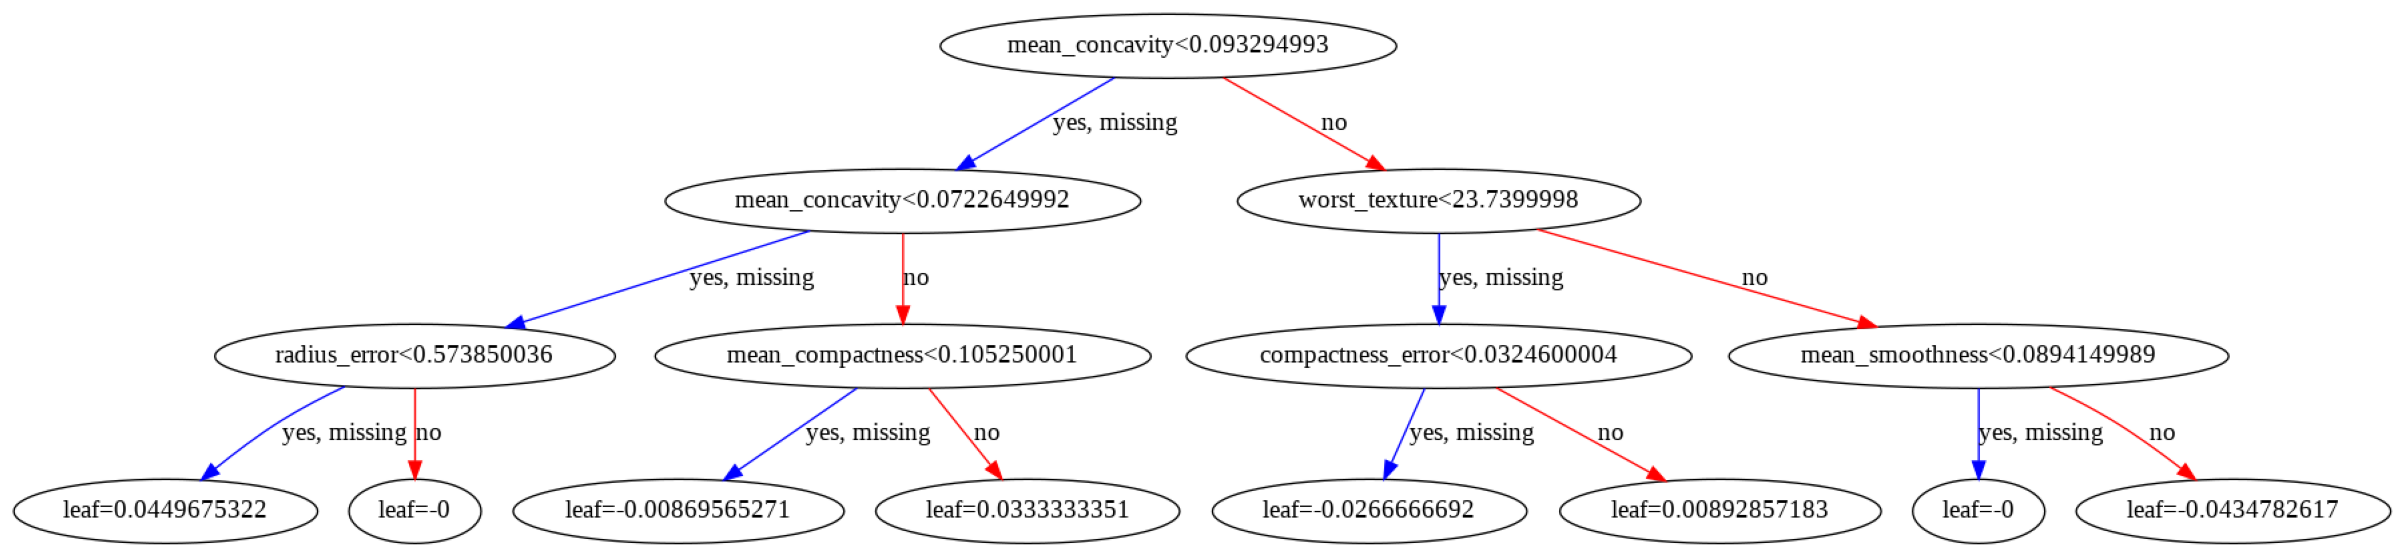

In [68]:
import matplotlib.pyplot as plt

xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [70, 70]
plt.show()

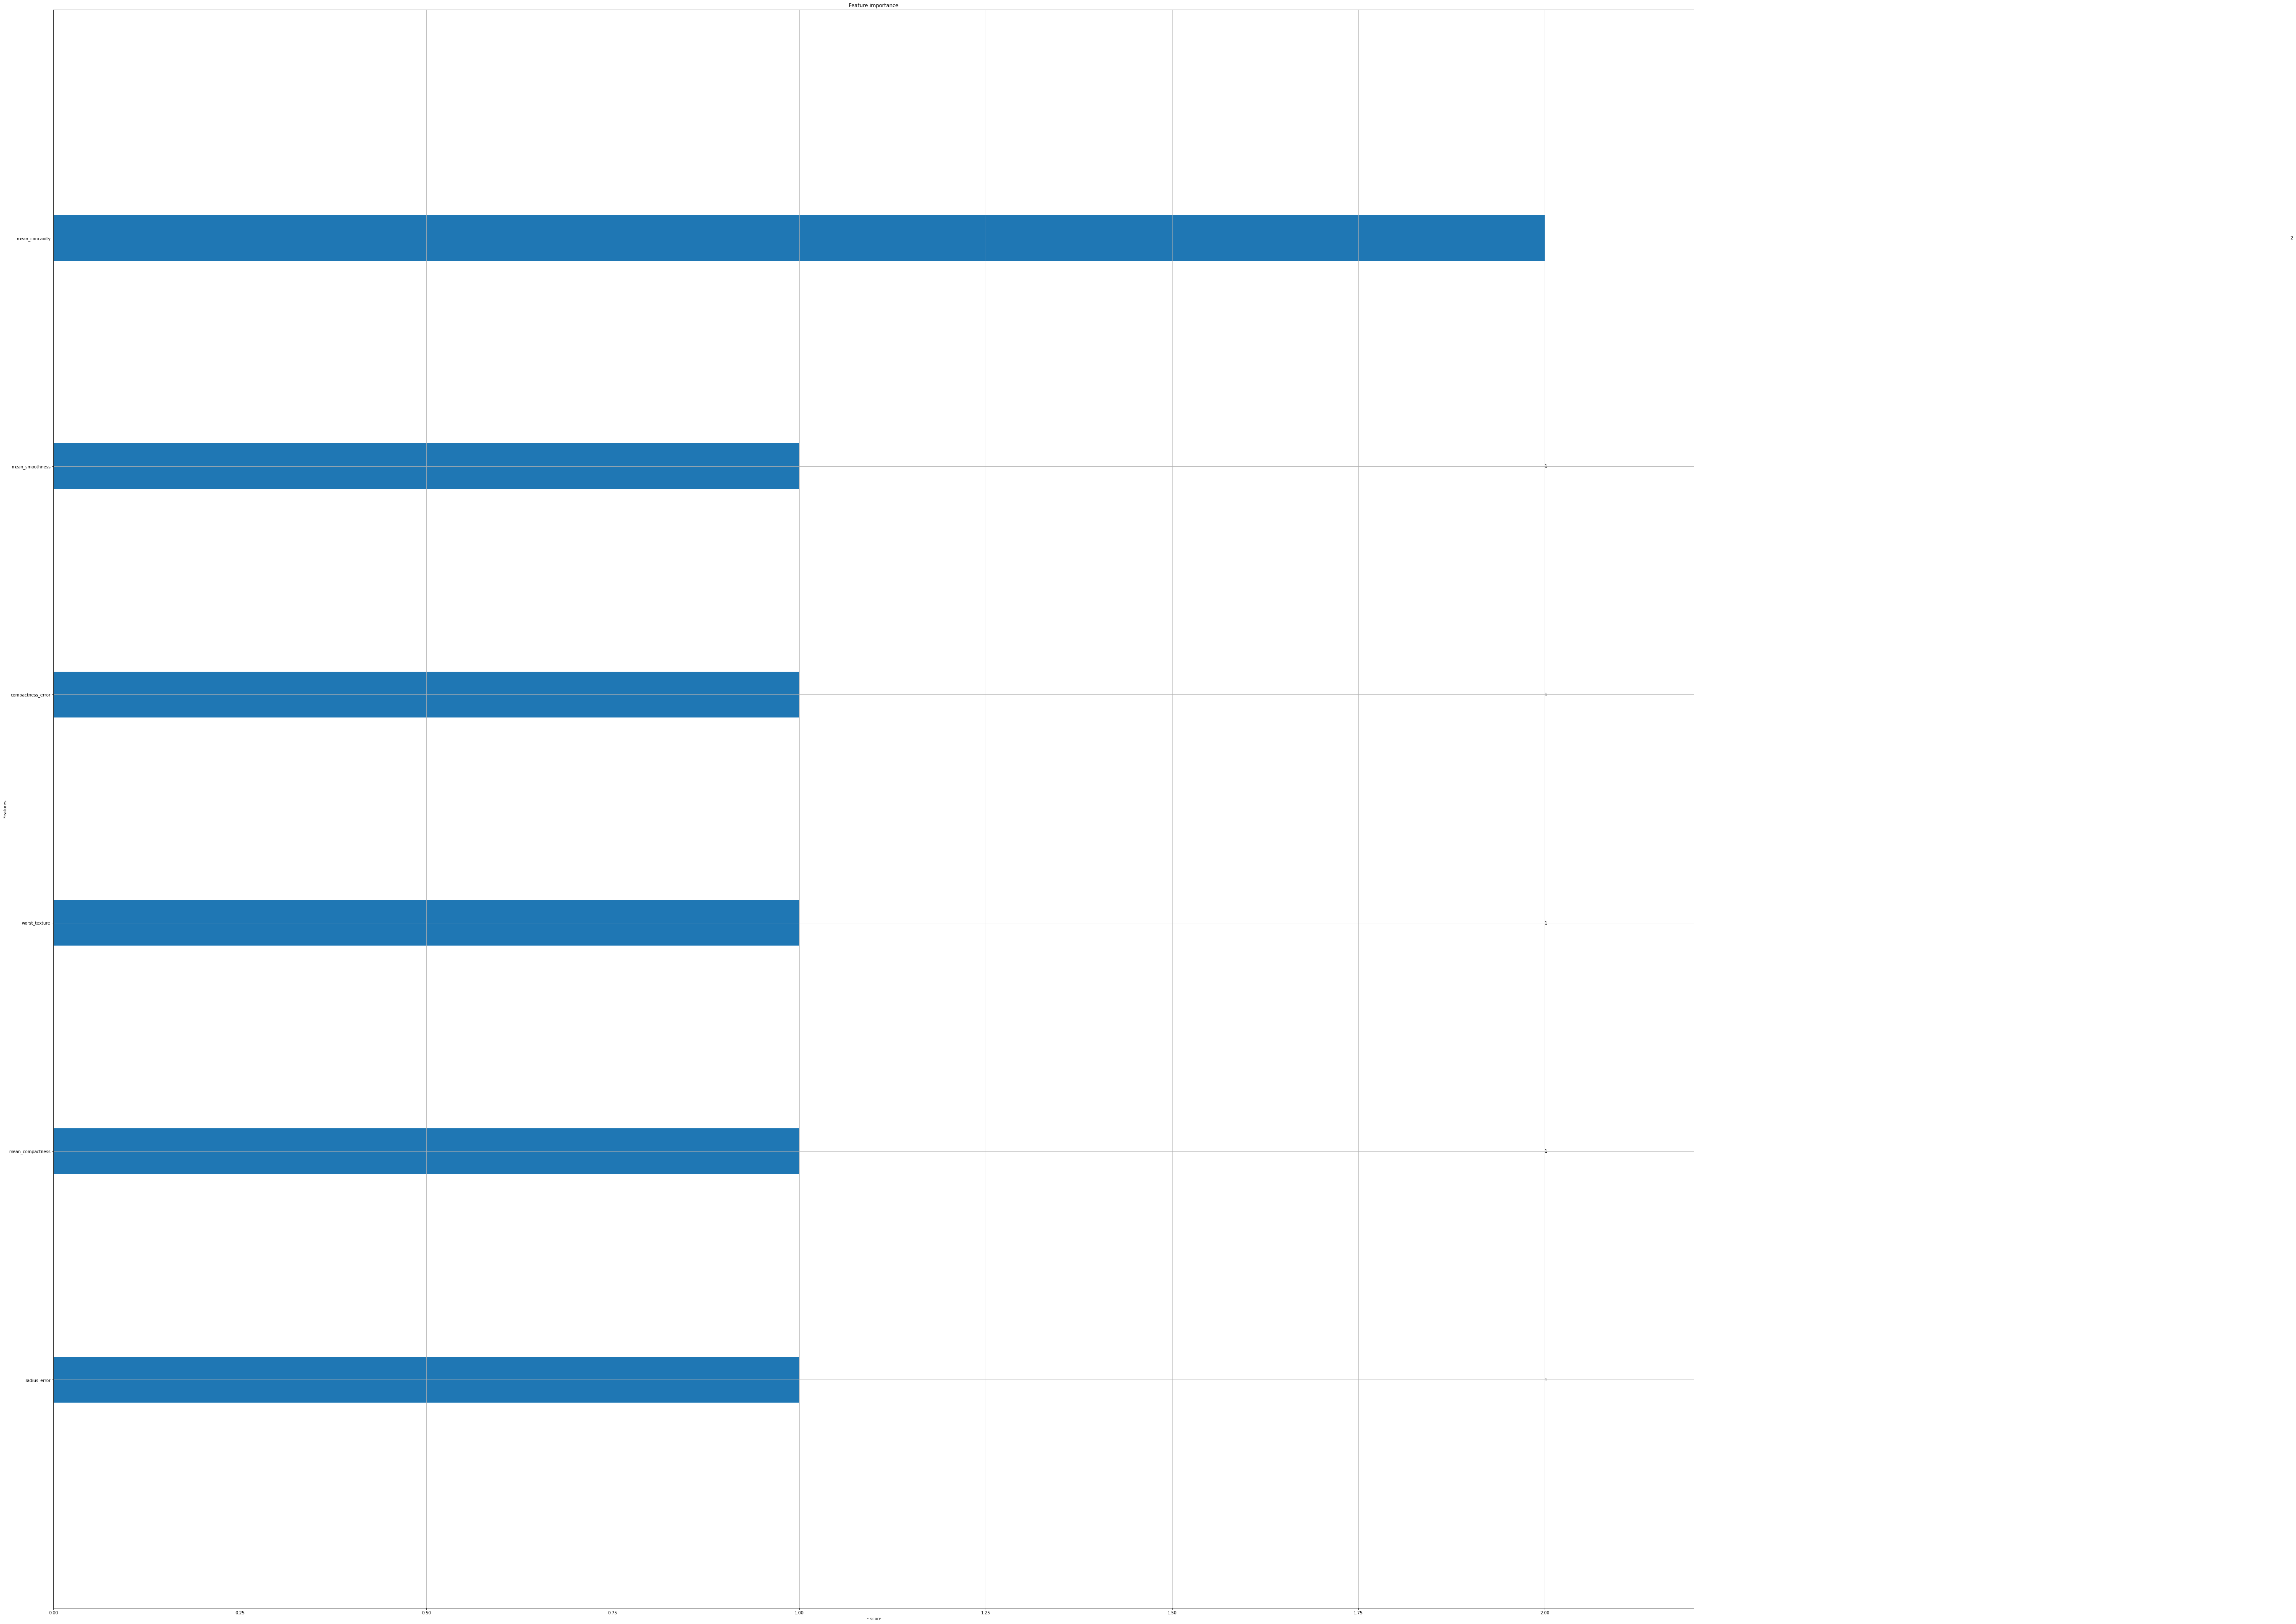

In [69]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

## CatBoost

In [70]:
pip install catboost

     |████████████████████████████████| 76.3 MB 1.5 MB/s 


In [71]:
import catboost as cb
import seaborn as sns

In [72]:
data.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,radius_error,texture_error,perimeter_error,area_error,smoothness_error,compactness_error,concavity_error,concave_points_error,symmetry_error,fractal_dimension_error,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [74]:
feature_cols = ['mean_radius','mean_texture','mean_perimeter','mean_area','mean_smoothness']
X=data[feature_cols]
y=data.diagnosis

In [77]:
from pandas.api.types import is_numeric_dtype

def get_category_index(X):
  categories = []
  for col in X.columns:
    if is_numeric_dtype(X[col]):
      pass
    else:
      categories.append(col)
  categories_indicies = []
  for col in categories:
    categories_indicies.append(X.columns.get_loc(col))
  return categories_indicies
categorical_indicies = get_category_index(X)

In [78]:
def convert_categories(X):
  categories = []
  for col in X.columns:
    if is_numeric_dtype(X[col]):
      pass
    else:
      categories.append(col)
  categories_indicies = []
  for col in categories:
    X[col] = X[col].astype('category')
convert_categories(X)

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101, stratify=y)

In [85]:
print('Diagnosis rate : {0}% '.format(round((y_test.sum()/y_test.count()),2) * 100))


Diagnosis rate : 63.0% 


In [86]:
model = cb.CatBoostClassifier(loss_function='Logloss', eval_metric='Accuracy')

In [89]:
train_df = pd.concat([X,y],axis=1)

diagnosed = train_df[train_df['diagnosis']==1]
misdiagnosed = train_df[train_df['diagnosis']==0]

misdiagnosed = misdiagnosed.sample(n=len(misdiagnosed), random_state=101)

train_df = pd.concat([diagnosed,misdiagnosed],axis=0)

X_train = train_df.drop('diagnosis',axis=1)
y_train = train_df['diagnosis']

train_dataset = cb.Pool(X_train,y_train, cat_features=categorical_indicies)
test_dataset = cb.Pool(X_test,y_test, cat_features=categorical_indicies)

In [ ]:
grid = {'learning_rate': [0.03, 0.1],
'depth': [4, 6, 10],
'l2_leaf_reg': [1, 3, 5,],
'iterations': [50, 100, 150]}
model.grid_search(grid,train_dataset)

In [92]:
pred = model.predict(X_test)
pred

array([1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0])

In [95]:
from sklearn.metrics import classification_report



In [97]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89        42
           1       0.93      0.94      0.94        72

    accuracy                           0.92       114
   macro avg       0.92      0.91      0.91       114
weighted avg       0.92      0.92      0.92       114



## Light GBM

In [98]:
X = data[feature_cols]
y = data['diagnosis']

In [99]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [100]:
import lightgbm as lgb
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

LGBMClassifier()

In [101]:
y_pred=clf.predict(X_test)

In [102]:
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.9240


In [103]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

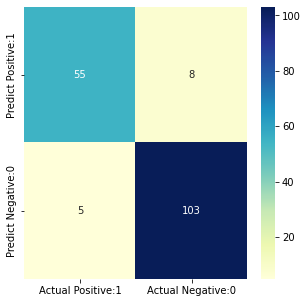

In [104]:
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

## Random Forest

In [105]:
from sklearn.ensemble import RandomForestClassifier

clf=RandomForestClassifier(n_estimators=100)

clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [106]:
from sklearn import metrics

print("RF Accuracy:",metrics.accuracy_score(y_test, y_pred))

RF Accuracy: 0.935672514619883


In [111]:
import pandas as pd
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)
feature_imp = pd.Series(clf.feature_importances_,index=feature_cols).sort_values(ascending=False)
feature_imp

mean_perimeter     0.326667
mean_area          0.235008
mean_radius        0.202382
mean_smoothness    0.120879
mean_texture       0.115063
dtype: float64

No handles with labels found to put in legend.


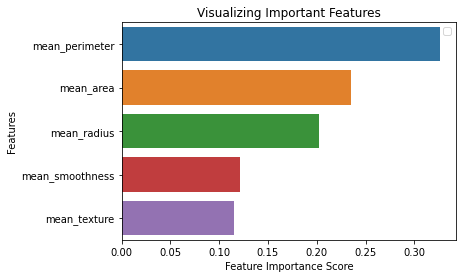

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

## AdaBoost 

In [113]:
from sklearn.ensemble import AdaBoostClassifier


adaboost = AdaBoostClassifier(n_estimators=50,learning_rate=1)

model = adaboost.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [114]:
print("AdaBoost Accuracy:",metrics.accuracy_score(y_test, y_pred))

AdaBoost Accuracy: 0.9122807017543859


## Decision tree classifier

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [118]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [119]:
print(" Decision Tree Accuracy:",metrics.accuracy_score(y_test, y_pred))

 Decision Tree Accuracy: 0.8654970760233918


In [120]:
!pip install graphviz
!pip install pydotplus
! pip install six

In [121]:
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

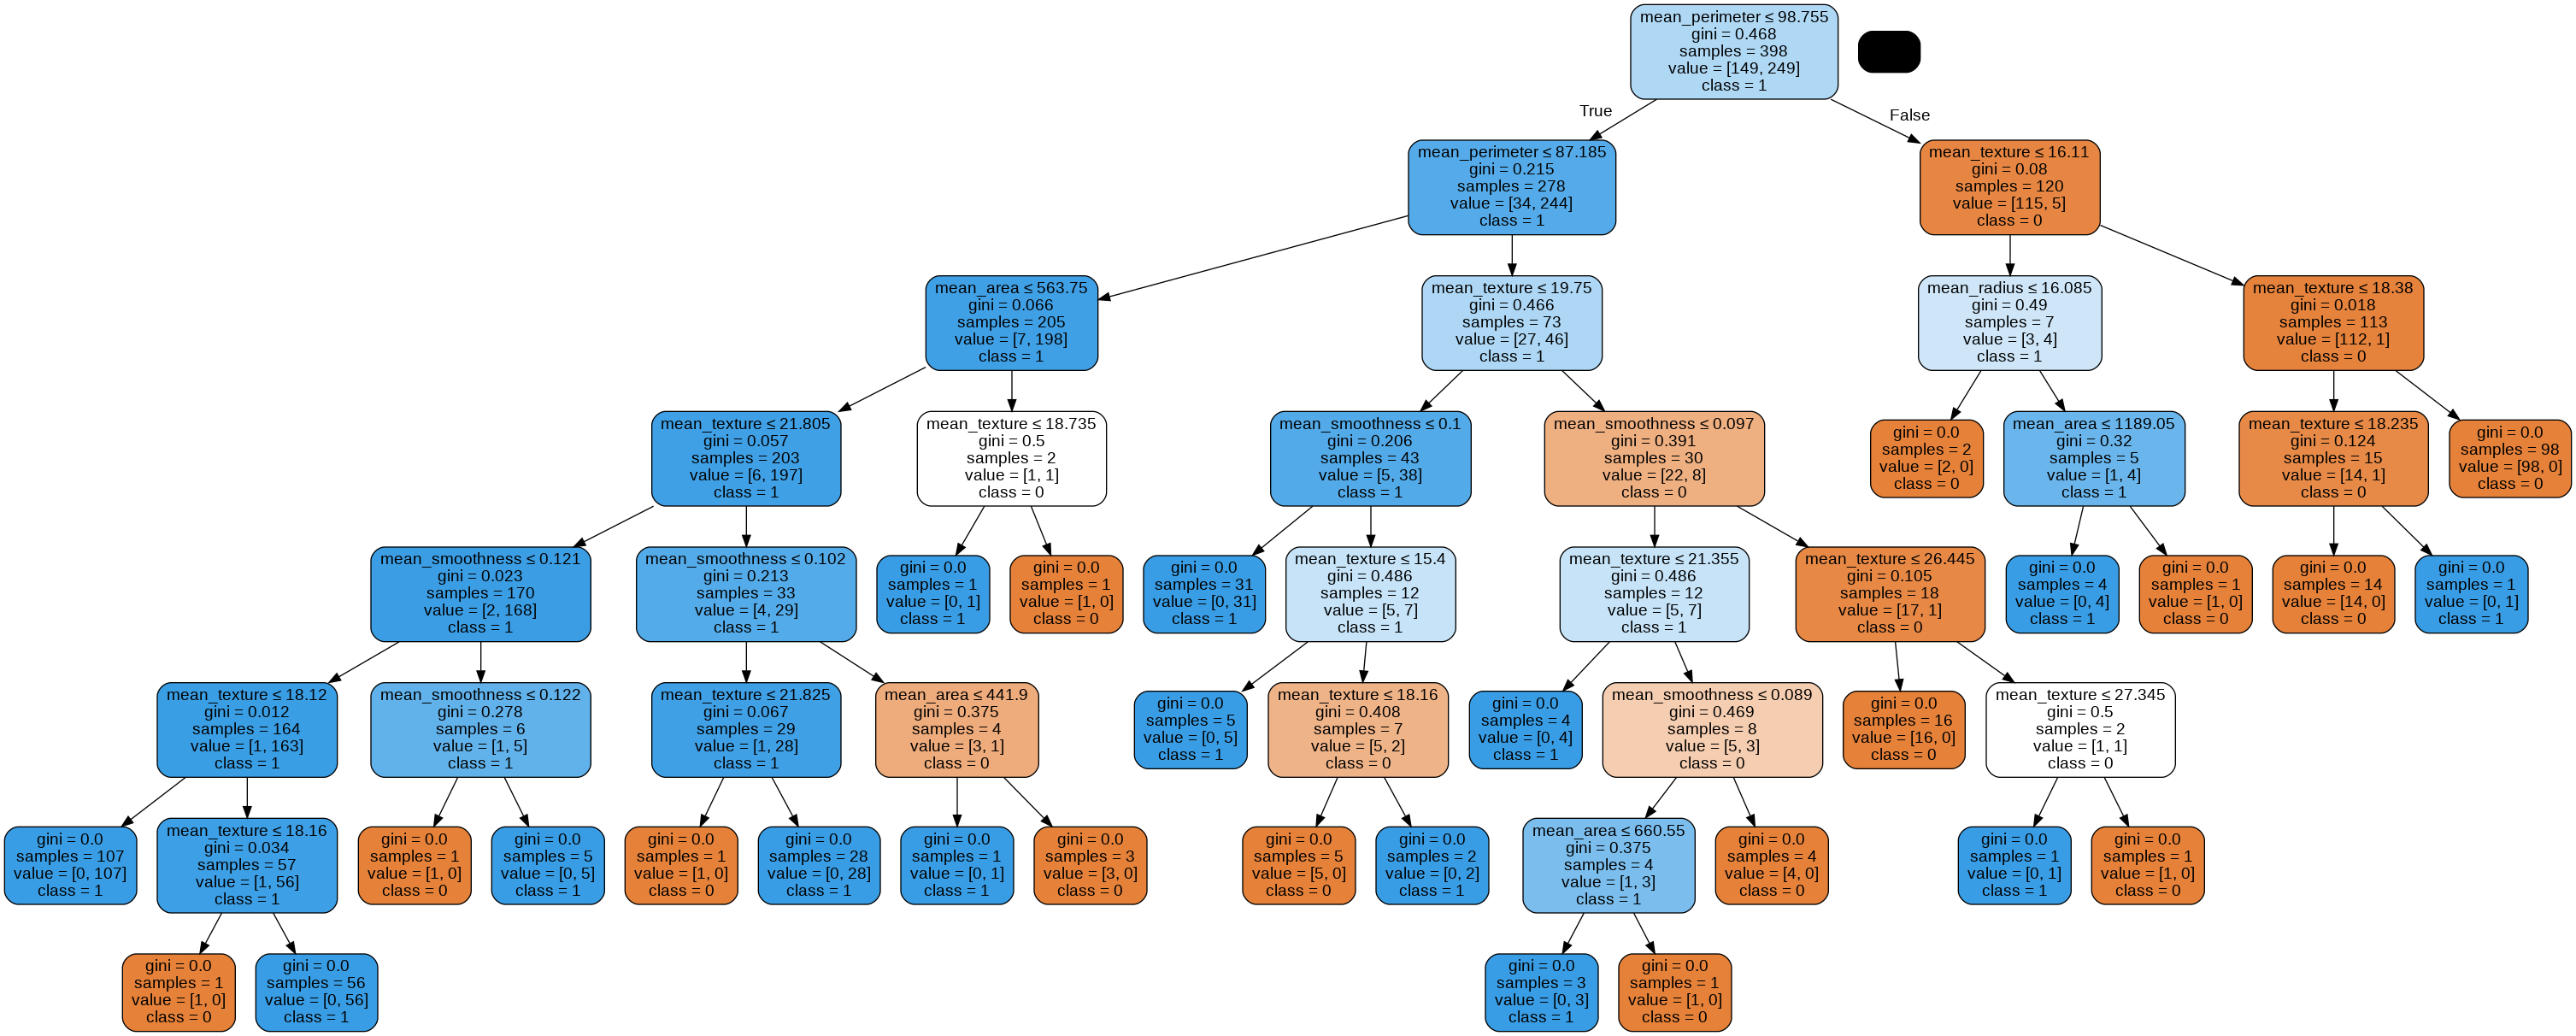

In [122]:
Image(graph.create_png())

## Regression 

### XGBoost

In [125]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

[00:53:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [126]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.353096


In [129]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

res2 = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

[00:54:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:54:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:54:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:54:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


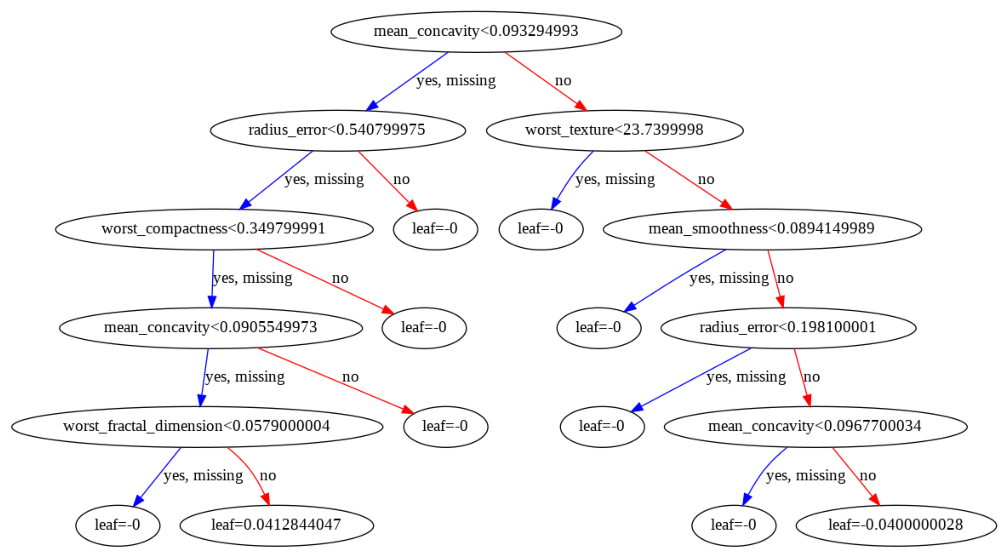

In [131]:
import matplotlib.pyplot as plt

xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [70,70]
plt.show()

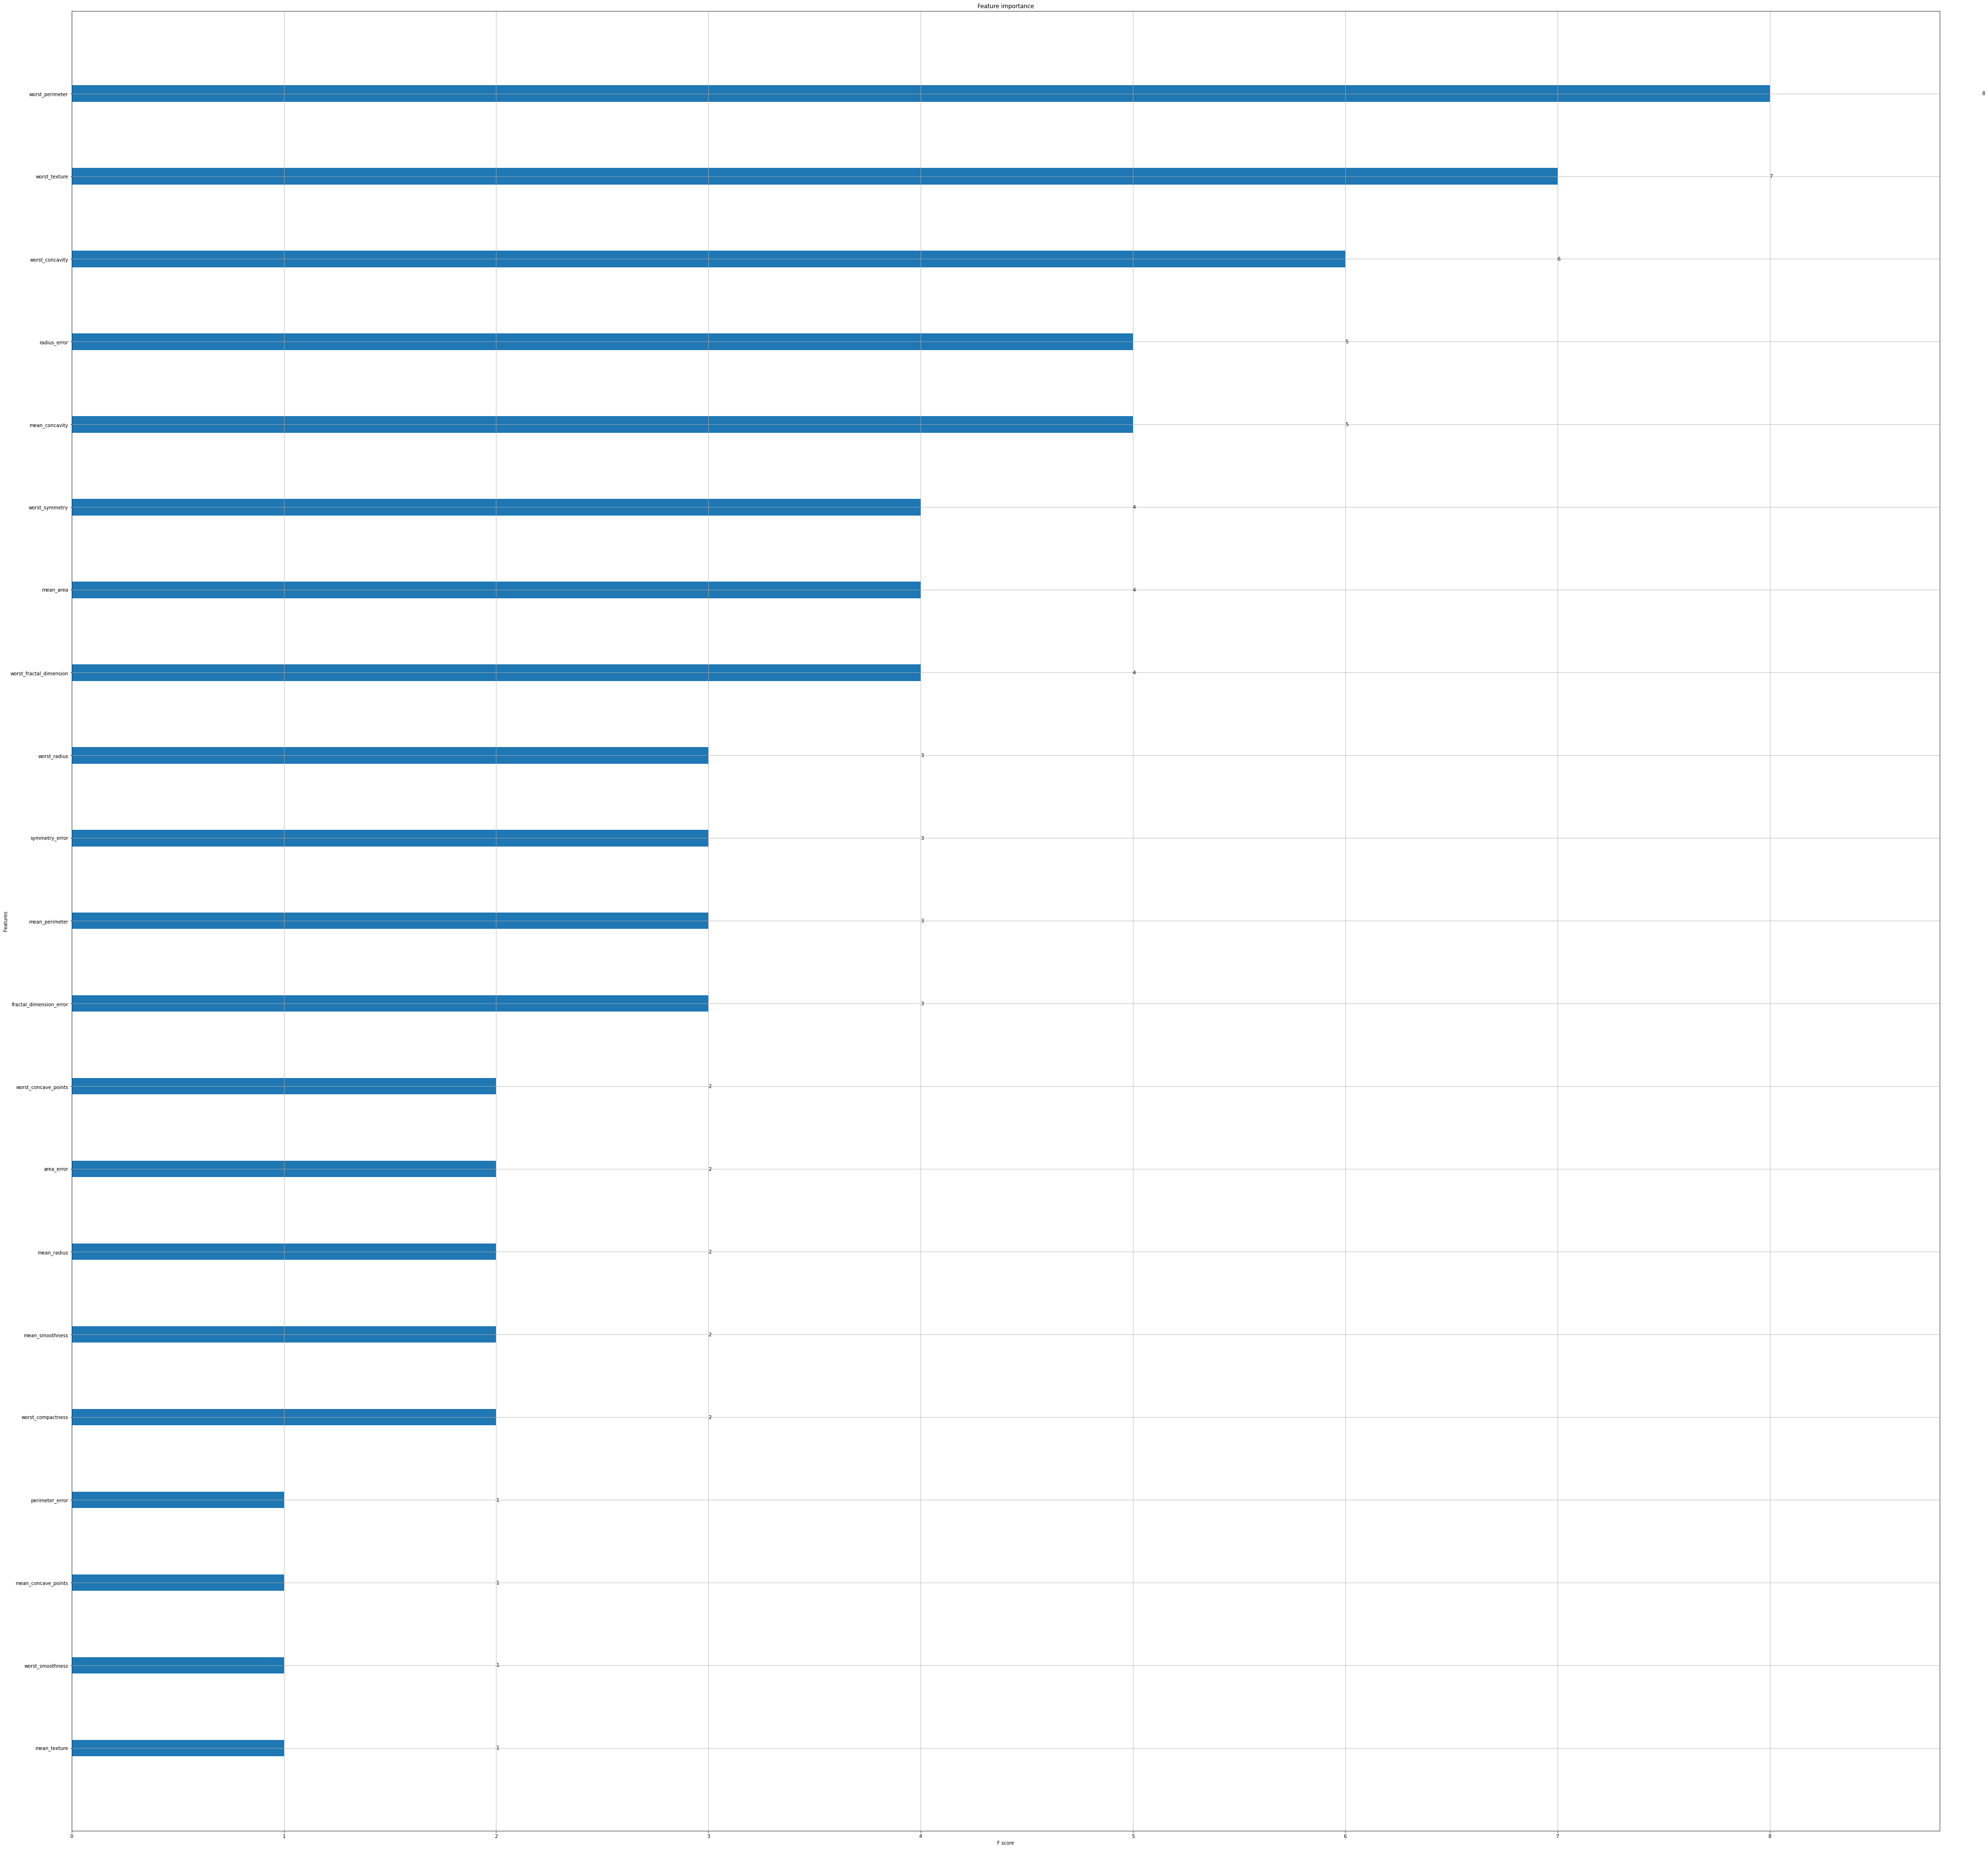

In [132]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

### CatBoost 

In [ ]:
import catboost as cb

train_dataset = cb.Pool(X_train, y_train) 
test_dataset = cb.Pool(X_test, y_test)
model = cb.CatBoostRegressor()

grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
model.grid_search(grid, train_dataset)

In [139]:
from sklearn.metrics import r2_score
pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)
print("RMSE: {0}".format(rmse))
print("R2: {0}".format(r2))

RMSE: 0.2704797398406783
R2: 0.6855892432285065


Text(0.5, 0, 'CatBoost Feature Importance')

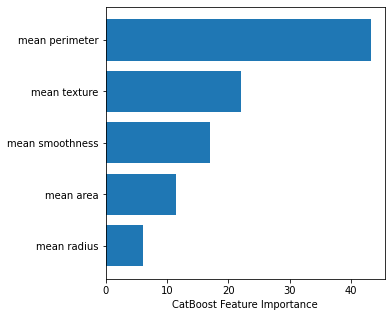

In [136]:
sorted_feature_importance = model.feature_importances_.argsort()
plt.barh(cancer_data.feature_names[sorted_feature_importance], 
        model.feature_importances_[sorted_feature_importance])
plt.xlabel("CatBoost Feature Importance")

### LightGBM

In [142]:
import lightgbm as lgbm
from sklearn.metrics import r2_score

reg = lgbm.LGBMRegressor()
reg.fit(X, y)

pred = reg.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)

print("RMSE: {0}".format(rmse))
print("R2: {0}".format(r2))

RMSE: 0.1211304400103997
R2: 0.9369428256850261


## Gradient Boost Ranking

In [143]:
from time import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import (RandomForestClassifier,
                              AdaBoostClassifier,
                              GradientBoostingClassifier,
                              HistGradientBoostingClassifier)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


In [144]:
X_train_sub, X_valid, y_train_sub, y_valid = train_test_split(X, y, test_size=0.1)

In [145]:
xgb = XGBClassifier(n_estimators=2000, tree_method='hist',subsample=0.67,colsample_level=0.06,verbose=0,n_jobs=6,random_state=1234)

cb = CatBoostClassifier(n_estimators=2000,colsample_bylevel=0.06,max_leaves=31,subsample=0.67,verbose=0,thread_count=6,random_state=1234)

lgbm = LGBMClassifier(n_estimators=2000,feature_fraction=0.06, bagging_fraction=0.67,bagging_freq=1,verbose=0, n_jobs=6,random_state=1234)

In [149]:
models = [xgb,cb, lgbm]
model_names = [i.__class__.__name__ for i in models]

model_name = ['XGBClassifier', 'CatBoostClassifier','LGBMClassifier']

In [152]:
res_df = pd.DataFrame(columns=['accuracy', 'run_time'])
for m, n in zip(models, model_names):
    start_time = time()
    if n in model_name:
        m.fit(X_train_sub, y_train_sub,eval_set = [(X_valid, y_valid)],early_stopping_rounds=15,verbose=0)
    else:
        m.fit(X_train, y_train)
    run_time = time() - start_time
    accuracy = np.mean(m.predict(X_valid) == y_valid)
    res_df.loc[n] = [accuracy, run_time]
    


In [153]:
res_df

,accuracy,run_time
XGBClassifier,0.947368,0.061427
CatBoostClassifier,0.894737,0.062418
LGBMClassifier,0.929825,0.395249
